# 1.  Imports

In [443]:
# generics
import pandas as pd
import numpy as np
import random

# visu
#import seaborn as sns
import matplotlib.pyplot as plt
#from wordcloud import WordCloud

# texts
import re


import unicodedata
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

# Model
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics

[nltk_data] Downloading package stopwords to /home/pk6142/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pk6142/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2.  Loading data

In [444]:
df_train = pd.read_csv("Training.csv")
df_test = pd.read_csv("Testing.csv")

In [445]:
df_train.tweet = df_train.tweet.astype(str)
df_test.tweet = df_test.tweet.astype(str)

In [446]:
df_train_new = df_train[df_train['subtask_a'] == "Offensive"]

In [447]:
df_test_new = df_test[df_test['subtask_a'] == "Offensive"]

In [448]:
df_test_new.subtask_b.unique()

array(['TIN', 'UNT'], dtype=object)

In [450]:
df_train_new.subtask_b.unique()

array(['TIN', 'UNT'], dtype=object)

# 3.  Data overview

In [451]:
df_train.head(5)

tweet  subtask_a subtask_b  \
0                    भिकारचोट पत्रकार दलाल आहेत साले  Offensive       TIN   
1  म्हणून हे परप्रांतीय लोंढे थांबवा आणि महाराष्ट...  Offensive       TIN   
2  छान लिहिला आहेपण त्या बावळट माणसांना असले स्पष...  Offensive       TIN   
3  एकदम मान्य नाहीतरी ही भिकारचोट मंडळी त्या सिने...  Offensive       TIN   
4                               भिकारचोट मराठी मीडि…  Offensive       TIN   

  subtask_c  
0       GRP  
1       GRP  
2       GRP  
3       GRP  
4       GRP

In [452]:
temp = df_train.groupby('subtask_a').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

In [453]:
temp = df_train.groupby('subtask_b').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

In [454]:
temp = df_train.groupby('subtask_c').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

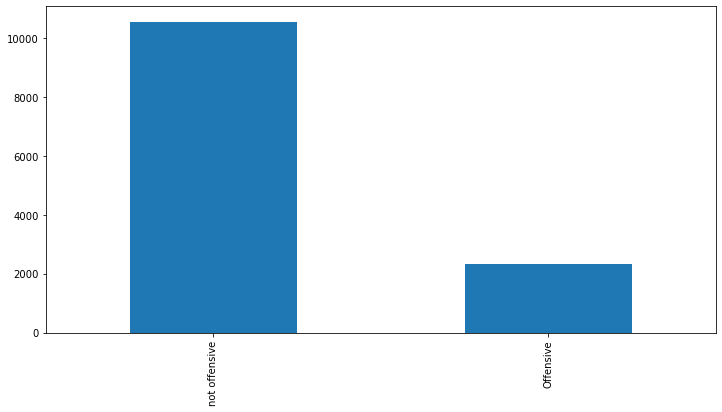

In [455]:
plt.figure(figsize=(12,6))
df_train['subtask_a'].value_counts().plot.bar()
plt.show()

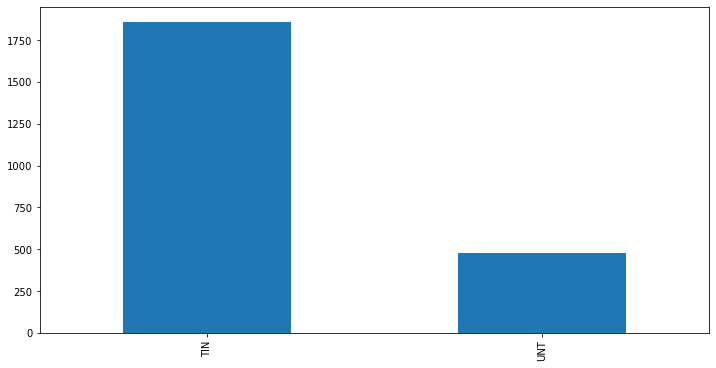

In [456]:
plt.figure(figsize=(12,6))
df_train['subtask_b'].value_counts().plot.bar()
plt.show()

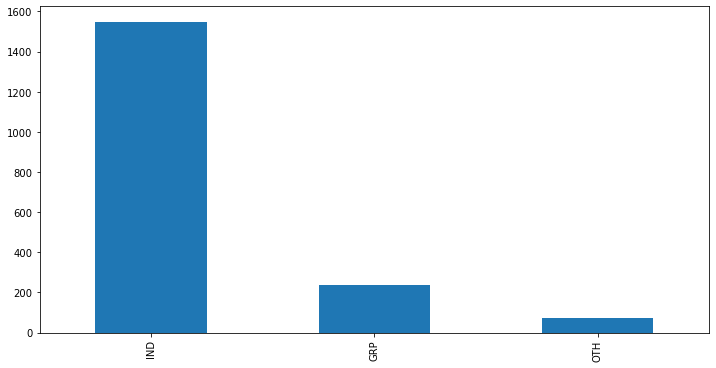

In [457]:
plt.figure(figsize=(12,6))
df_train['subtask_c'].value_counts().plot.bar()
plt.show()

In [458]:
class_df = df_train.groupby('subtask_a').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
class_df.style.background_gradient(cmap='winter')

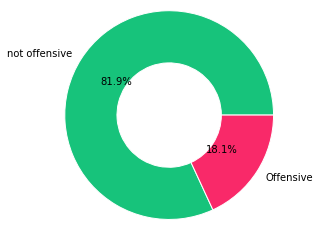

In [459]:
percent_class=class_df.tweet
labels= class_df.subtask_a

colors = ['#17C37B','#F92969','#FACA0C']

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.6, edgecolor='white') 

plt.show()

In [460]:
class_df = df_train.groupby('subtask_b').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
class_df.style.background_gradient(cmap='winter')

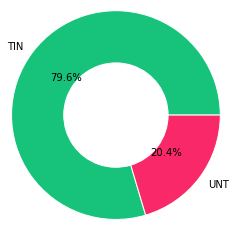

In [461]:
percent_class=class_df.tweet
labels= class_df.subtask_b

colors = ['#17C37B','#F92969','#FACA0C']

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.6, edgecolor='white') 

plt.show()

In [462]:
class_df = df_train.groupby('subtask_c').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
class_df.style.background_gradient(cmap='winter')

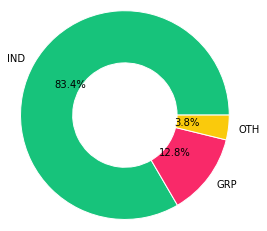

In [463]:
percent_class=class_df.tweet
labels= class_df.subtask_c

colors = ['#17C37B','#F92969','#FACA0C']

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.6, edgecolor='white') 

plt.show()

# 5. Cleaning tweets

In [464]:

import re
import pandas as pd


# pre-processing the data
def clean_text(row, options):

    if options['lowercase']:
        row = str(row).lower()

    if options['strip_spaces']:
        row = str(row).strip()

    if options['remove_url']:
        row = str(row).replace('http\S+|www.\S+', '')

    if options['remove_mentions']:
        row = re.sub("@[A-Za-z0-9]+","@USER",row)

    if options['remove_newline']:
        row = re.sub(r'\n',' ',row)

    if options['remove_tab']:
        row = re.sub(r'\t',' ',row)

    if options['remove_english']:
        row = re.sub("[A-Za-z0-9]+","",row)

    if options['add_USER_tag']:
        row = re.sub("@","@USER",row)

    if options['remove_specials']:
        row = re.sub('[+,-,_,=,/,<,>,!,#,$,%,^,&,*,\",:,;,.,' ',\t,\r,\n,\',|]','',row)
    return row

clean_config = {
    'remove_url': True,
    'remove_mentions': True,
    'decode_utf8': True,
    'lowercase': True,
    'remove_english': True,
    'remove_specials': True,
    'add_USER_tag': True,
    'remove_newline':True,
    'remove_tab':True,
    'strip_spaces':True
    }


def demoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U00010000-\U0010ffff"
                               "]+", flags=re.UNICODE)
    return(emoji_pattern.sub(r'', text))


def main():
    dataset = df_test_new

    dataset_df = pd.DataFrame(dataset)

    dataset_df = dataset_df[["tweet","subtask_a","subtask_b","subtask_c"]]
    #, "subtask_c", "subtask_b", "subtask_c"

    #lowe case conversion
    dataset_df['tweet'] = dataset_df['tweet'].str.lower()

    # calling pre-processing function
    dataset_df['tweet'] = dataset_df['tweet'].apply(clean_text, args=(clean_config,))

    #stripping leading and trailing whitespaces
    dataset_df['tweet'] = dataset_df['tweet'].str.strip()

    #remove emojis - not working
    dataset_df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

    #remove emojis - working
    dataset_df['tweet'] = dataset_df['tweet'].apply( lambda x : demoji(x))

    # convert df to csv
    dataset_df.to_csv('testing_cleaned_new.csv',index = False)

if __name__ == "__main__":
    main()

In [465]:

import re
import pandas as pd


# pre-processing the data
def clean_text(row, options):

    if options['lowercase']:
        row = str(row).lower()

    if options['strip_spaces']:
        row = str(row).strip()

    if options['remove_url']:
        row = str(row).replace('http\S+|www.\S+', '')

    if options['remove_mentions']:
        row = re.sub("@[A-Za-z0-9]+","@USER",row)

    if options['remove_newline']:
        row = re.sub(r'\n',' ',row)

    if options['remove_tab']:
        row = re.sub(r'\t',' ',row)

    if options['remove_english']:
        row = re.sub("[A-Za-z0-9]+","",row)

    if options['add_USER_tag']:
        row = re.sub("@","@USER",row)

    if options['remove_specials']:
        row = re.sub('[+,-,_,=,/,<,>,!,#,$,%,^,&,*,\",:,;,.,' ',\t,\r,\n,\',|]','',row)
    return row

clean_config = {
    'remove_url': True,
    'remove_mentions': True,
    'decode_utf8': True,
    'lowercase': True,
    'remove_english': True,
    'remove_specials': True,
    'add_USER_tag': True,
    'remove_newline':True,
    'remove_tab':True,
    'strip_spaces':True
    }


def demoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U00010000-\U0010ffff"
                               "]+", flags=re.UNICODE)
    return(emoji_pattern.sub(r'', text))


def main():
    dataset = df_train_new

    dataset_df = pd.DataFrame(dataset)

    dataset_df = dataset_df[["tweet","subtask_a","subtask_b","subtask_c"]]
    #, "subtask_c", "subtask_b", "subtask_c"

    #lowe case conversion
    dataset_df['tweet'] = dataset_df['tweet'].str.lower()

    # calling pre-processing function
    dataset_df['tweet'] = dataset_df['tweet'].apply(clean_text, args=(clean_config,))

    #stripping leading and trailing whitespaces
    dataset_df['tweet'] = dataset_df['tweet'].str.strip()

    #remove emojis - not working
    dataset_df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

    #remove emojis - working
    dataset_df['tweet'] = dataset_df['tweet'].apply( lambda x : demoji(x))

    # convert df to csv
    dataset_df.to_csv('training_cleaned_new.csv',index = False)

if __name__ == "__main__":
    main()

In [422]:
# # df_train.subtask_a = df_train.subtask_a.dropna()
# # df_train = df_train.reset_index(drop=True)

# df_train.subtask_b = df_train.subtask_b.dropna()
# df_train = df_train.reset_index(drop=True)

# # df_train.subtask_c = df_train.subtask_c.dropna()
# # df_train = df_train.reset_index(drop=True)


# # df_test.subtask_a = df_test.subtask_a.dropna()
# # df_test = df_test.reset_index(drop=True)

# df_test.subtask_b = df_test.subtask_b.dropna()
# df_test = df_test.reset_index(drop=True)

# # df_test.subtask_c = df_test.subtask_c.dropna()
# # df_test = df_test.reset_index(drop=True)

In [423]:
temp = df_train.groupby('subtask_b').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

In [424]:
temp = df_test.groupby('subtask_b').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

In [466]:
train_df = pd.read_csv('training_cleaned_new.csv')
test_df = pd.read_csv('testing_cleaned_new.csv')

train_df.tweet = train_df.tweet.astype(str)
test_df.tweet = test_df.tweet.astype(str)

In [467]:
train_df.head(5)

tweet  subtask_a subtask_b  \
0                    भिकारचोट पत्रकार दलाल आहेत साले  Offensive       TIN   
1  म्हणून हे परप्रांतीय लोंढे थांबवा आणि महाराष्ट...  Offensive       TIN   
2  छान लिहिला आहेपण त्या बावळट माणसांना असले स्पष...  Offensive       TIN   
3  एकदम मान्य नाहीतरी ही भिकारचोट मंडळी त्या सिने...  Offensive       TIN   
4                               भिकारचोट मराठी मीडि…  Offensive       TIN   

  subtask_c  
0       GRP  
1       GRP  
2       GRP  
3       GRP  
4       GRP

In [468]:
train_df['subtask_b'].unique()

array(['TIN', 'UNT'], dtype=object)

In [469]:
test_df['subtask_b'].unique()

array(['TIN', 'UNT'], dtype=object)

In [326]:
# train_df.subtask_a = train_df.subtask_a.dropna()
# train_df = train_df.reset_index(drop=True)

train_df.subtask_b = train_df.subtask_b.dropna()
train_df = train_df.reset_index(drop=True)

# train_df.subtask_c = train_df.subtask_c.dropna()
# train_df = train_df.reset_index(drop=True)


# test_df.subtask_a = test_df.subtask_a.dropna()
# test_df = test_df.reset_index(drop=True)

test_df.subtask_b = test_df.subtask_b.dropna()
test_df = test_df.reset_index(drop=True)

# test_df.subtask_c = test_df.subtask_c.dropna()
# test_df = test_df.reset_index(drop=True)

In [470]:
temp = df_train.groupby('subtask_b').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

In [471]:
temp = df_test.groupby('subtask_b').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

# 6.  Looking at data

<b>Sentiment repartition:</b>

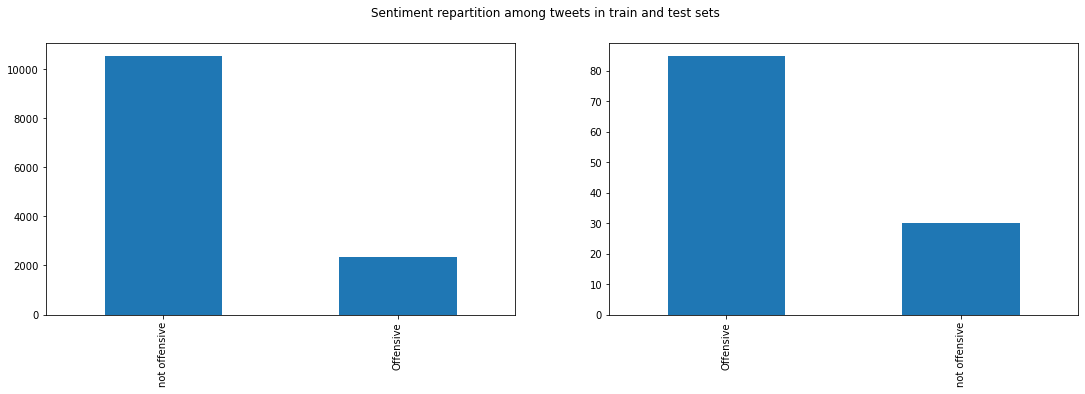

In [329]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5)
fig.suptitle('Sentiment repartition among tweets in train and test sets')
train_df["subtask_a"].value_counts().plot(kind="bar", ax=ax1);
test_df["subtask_a"].value_counts().plot(kind="bar", ax=ax2);

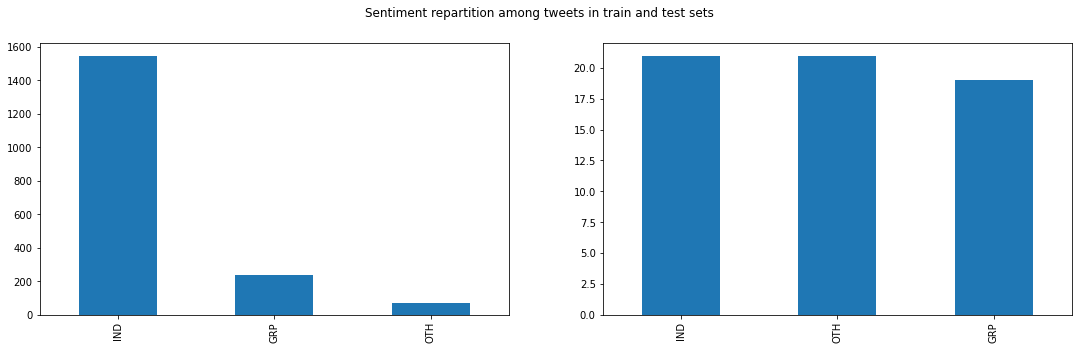

In [330]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5)
fig.suptitle('Sentiment repartition among tweets in train and test sets')
train_df["subtask_c"].value_counts().plot(kind="bar", ax=ax1);
test_df["subtask_c"].value_counts().plot(kind="bar", ax=ax2);

<b>Word cloud in each sentiment categories:</b>

In [331]:
# all_words_positive = " ".join([text for text in df_train[df_train["Sentiment"]=="Positive"]["CleanTweet"]])
# all_words_neutral = " ".join([text for text in df_train[df_train["Sentiment"]=="Neutral"]["CleanTweet"]])
# all_words_negative = " ".join([text for text in df_train[df_train["Sentiment"]=="Negative"]["CleanTweet"]])

In [332]:
# wordcloud_positive = WordCloud(width=800, height=600, max_font_size=120, background_color="white", colormap="Greens").generate(all_words_positive)
# wordcloud_neutral = WordCloud(width=800, height=600, max_font_size=120, background_color="white", colormap="YlOrBr").generate(all_words_neutral)
# wordcloud_negative = WordCloud(width=800, height=600, max_font_size=120, background_color="white", colormap="Reds").generate(all_words_negative)

In [333]:
# parameters = {'axes.labelsize': 12,
#               'axes.titlesize': 10}
# #
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# fig.set_size_inches(18.5, 7)
# ax1.imshow(wordcloud_positive, interpolation='bilinear')
# ax1.axis("off")
# ax1.set_title("WordCloud of positive tweets", fontsize=12)
# ax2.imshow(wordcloud_neutral, interpolation='bilinear')
# ax2.axis("off")
# ax2.set_title("WordCloud of neutral tweets", fontsize=12)
# ax3.imshow(wordcloud_negative, interpolation='bilinear')
# ax3.axis("off")
# ax3.set_title("WordCloud of negative tweets", fontsize=12)
# plt.rcParams.update(parameters)
# plt.show()

# 7. Sentiment encoding

In [472]:
df_train_encoded = train_df.copy()
df_test_encoded = test_df.copy()
#
print("train set shape: " + str(df_train_encoded.shape))
print("test set shape: " + str(df_test_encoded.shape))

train set shape: (2333, 4)
test set shape: (85, 4)


In [473]:
map_sentiment = {"TIN":0, "UNT":1}
df_train_encoded['subtask_b'] = df_train_encoded['subtask_b'].map(map_sentiment)
df_test_encoded['subtask_b']  = df_test_encoded['subtask_b'].map(map_sentiment)



In [474]:
df_train_encoded['subtask_b'].unique()

array([0, 1])

In [475]:
df_test_encoded['subtask_b'].unique()

array([0, 1])

In [340]:
df_train_encoded

tweet      subtask_a  \
0                        भिकारचोट पत्रकार दलाल आहेत साले      Offensive   
1      म्हणून हे परप्रांतीय लोंढे थांबवा आणि महाराष्ट...      Offensive   
2      छान लिहिला आहेपण त्या बावळट माणसांना असले स्पष...      Offensive   
3      एकदम मान्य नाहीतरी ही भिकारचोट मंडळी त्या सिने...      Offensive   
4                                   भिकारचोट मराठी मीडि…      Offensive   
...                                                  ...            ...   
12875  पहिल्या लाटे नंतर सर्वात कमी रुग्ण कोरोना रूग्...  not offensive   
12876  @USER @USER जगातले सर्वात कट्टर धूर्त  एकत्र य...  not offensive   
12877  देशातील सर्वात स्वस्त इलेक्ट्रिक कार एका चार्ज...  not offensive   
12878  @USER पंतप्रधान आयुष्मान भारत आरोग्यविषयक पाया...  not offensive   
12879  @USER काटकसर म्हणजे गोधड्या शिवणे चिंध्या भरून...  not offensive   

       subtask_b subtask_c  
0              1       GRP  
1              1       GRP  
2              1       GRP  
3              1       GRP  
4              1       GRP  
...          ...       ...  
12875          0       NaN  
12876          0       NaN  
12877          0       NaN  
12878          0       NaN  
12879          0       NaN  

[12880 rows x 4 columns]

# 8. Feature and target preparation

In [476]:
y_train = train_df['subtask_b'].copy()
y_test = test_df['subtask_b'].copy()

y_train_encoded = to_categorical(df_train_encoded['subtask_b'],2)
y_test_encoded = to_categorical(df_test_encoded['subtask_b'],2)

y_train_mapped = df_train_encoded['subtask_b'].copy()
y_test_mapped = df_test_encoded['subtask_b'].copy()

X_train = df_train_encoded[['tweet']].copy()
X_test = df_test_encoded[['tweet']].copy()

In [346]:
print(y_test)

0       TIN
1       TIN
2       TIN
3       TIN
4       TIN
       ... 
110    NULL
111    NULL
112    NULL
113    NULL
114    NULL
Name: subtask_b, Length: 115, dtype: object


In [347]:
print(len(y_train_mapped))

12880


# 9. Tokenization, sequences, padding

<b>The result of tokenizer is a dictionnary with:</b><br>
* key = word<br>
* value = unique number

In [348]:
y_train_encoded.shape

(12880,)

In [349]:
y_test_encoded.shape

(115,)

In [350]:
y_train_mapped.shape

(12880,)

In [351]:
y_test_mapped.shape

(115,)

In [352]:
X_train.shape

(12880, 1)

In [353]:
print(y_train.shape)

(12880,)


In [477]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train["tweet"])
vocab_length = len(tokenizer.word_index) + 1
vocab_length

6528

The <b>texts_to_sequences</b> function first transforms a text into list of words. Then, thanks to the dictionnary previously created by the tokenizer (see above), transforms list of list of words into list of list of numbers

In [478]:
X_train = tokenizer.texts_to_sequences(X_train["tweet"])
X_test = tokenizer.texts_to_sequences(X_test["tweet"])

Each tweets has differents length. Thus the result of the <b>texts_to_sequences</b> function will be a list of list of numbers of different length: 

In [479]:
print("First tweet encoded:")
print(X_train[0])
print("\nSecond tweet encoded:")
print(X_train[1])
print("\nThird tweet encoded:")
print(X_train[2])

First tweet encoded:
[31, 220, 675, 15, 320]

Second tweet encoded:
[47, 13, 1473, 1953, 1954, 3, 258, 1032, 321, 56, 1033, 1955, 1474]

Third tweet encoded:
[841, 842, 843, 29, 8, 844, 221, 845, 846, 4, 242, 24, 222, 34, 1475]


To feed the deep learning model, we need all these lists to be the same length. Thus we need to apply padding. In other words, we are going to add several zeros (0) at the end of the shortest tweets so that at the end, all of our lists have the same length. <br><br>
First let's get the maximum number of words in one tweet:

In [480]:
max_word_count = 0
word_count = []
#
for encoded_tweet in X_train:
    word_count.append(len(encoded_tweet))
    if len(encoded_tweet) > max_word_count:
        max_word_count = len(encoded_tweet)
print("Maximum number of word in one tweet: " + str(max_word_count) + " words")

Maximum number of word in one tweet: 28 words


So the longest tweet we have is composed of 39 words. We are going to pad the sequences with a maximum length of 37.

In [481]:
X_train = pad_sequences(X_train, maxlen=max_word_count, padding='post')
X_test = pad_sequences(X_test, maxlen=max_word_count, padding='post')
X_train.shape

(2333, 28)

Let's have a look at the encoded 3 tweets after padding:

In [482]:
print("First tweet encoded:", "Size = ", len(X_train[0]))
print(X_train[0])
print("\nSecond tweet encoded:", "Size = ", len(X_train[1]))
print(X_train[1])
print("\nThird tweet encoded:", "Size = ", len(X_train[2]))
print(X_train[2])

First tweet encoded: Size =  28
[ 31 220 675  15 320   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]

Second tweet encoded: Size =  28
[  47   13 1473 1953 1954    3  258 1032  321   56 1033 1955 1474    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]

Third tweet encoded: Size =  28
[ 841  842  843   29    8  844  221  845  846    4  242   24  222   34
 1475    0    0    0    0    0    0    0    0    0    0    0    0    0]


Now every encoded tweet has the same length, the data is ready for the model.

# 10. Model

<b>The model is composed of:</b>
1. <b>An embedding layer with parameters</b>
    * input dim = vocabulary size
    * output dim = 32
    * input length = size of padded sequences
    * mask_zero = True to ignore 0 (from padding)
2. <b>An LSTM (Long Short Term Memory) Layer with parameter</b>
    * units = 100 (the resulting accuracy is almost the same regardless this value)
3. <b>Three Dense layers</b>
4. <b>An output dense layer with parameters</b>
    * units = 3 (output dim)
    * activation = softmax (for multiclassification problem)

<b>Compilation with parameters:</b>
1. loss = categorical_crossentropy (for multiclassification problem)
2. optimizer = adam
3. metrics = accuracy

In [483]:
model_LSTM = Sequential()
model_LSTM.add(layers.Embedding(vocab_length, output_dim=32, input_length=max_word_count, mask_zero=True))
model_LSTM.add(layers.LSTM(100))
model_LSTM.add(layers.Dense(64, activation="relu"))
model_LSTM.add(layers.Dense(32, activation="relu"))
model_LSTM.add(layers.Dense(16, activation="relu"))
model_LSTM.add(layers.Dense(2, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_LSTM.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 28, 32)            208896    
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_36 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_37 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_38 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 34        
Total params: 271,202
Trainable params: 271,202
Non-trainable params: 0
________________________________________________

Here I set an early stopping after 10 epochs and set the parameter <i><b>restore_best_weights</b></i> to <b style="color:green">True</b> so that the weights of best score on monitored metric - here <b>val_accuracy</b> (accuracy on test set) - are restored when training stops. This way the model has the best accuracy possible on unseen data.

In [485]:
es = EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True)
history = model_LSTM.fit(X_train,
                         y_train_encoded,
                         validation_data=(X_test, y_test_encoded),
                         epochs=30,
                         batch_size=16,
                         verbose=2,
                         callbacks=[es]
                        )

Epoch 1/30
146/146 - 2s - loss: 0.0806 - accuracy: 0.9456 - val_loss: 1.6334 - val_accuracy: 0.7294
Epoch 2/30
146/146 - 2s - loss: 0.0802 - accuracy: 0.9383 - val_loss: 2.4210 - val_accuracy: 0.7765
Epoch 3/30
146/146 - 2s - loss: 0.0875 - accuracy: 0.9404 - val_loss: 1.1199 - val_accuracy: 0.8118
Epoch 4/30
146/146 - 2s - loss: 0.0851 - accuracy: 0.9430 - val_loss: 1.2180 - val_accuracy: 0.7529
Epoch 5/30
146/146 - 2s - loss: 0.0831 - accuracy: 0.9357 - val_loss: 2.5632 - val_accuracy: 0.7765
Epoch 6/30
146/146 - 2s - loss: 0.0887 - accuracy: 0.9378 - val_loss: 1.5313 - val_accuracy: 0.8118
Epoch 7/30
146/146 - 2s - loss: 0.0832 - accuracy: 0.9451 - val_loss: 1.9862 - val_accuracy: 0.8118
Epoch 8/30
146/146 - 2s - loss: 0.0833 - accuracy: 0.9430 - val_loss: 1.8535 - val_accuracy: 0.8118
Epoch 9/30
146/146 - 2s - loss: 0.0786 - accuracy: 0.9417 - val_loss: 2.1006 - val_accuracy: 0.8000
Epoch 10/30
146/146 - 2s - loss: 0.0798 - accuracy: 0.9443 - val_loss: 1.9095 - val_accuracy: 0.8118

We can see that after epoch 2, the accuracy on test set - val_accuracy - doesn't increase any more while accuracy on train set continues to increase untill almost 100%! The model is overfitting from epoch 2 and is not able to generalize well on unseen data from there.

# 11. Model Evaluation

<b>Prediction on test set:</b>

In [486]:
predicted = model_LSTM.predict(X_test)
y_pred = predicted.argmax(axis=-1)

<b>Calculation of accuracy and Area Under (ROC) Curve - AUC - scores:</b>

In [487]:
acc_score = accuracy_score(y_test_mapped, y_pred)
#auc_score = roc_auc_score(y_test_mapped, predicted, multi_class="ovr")

In [488]:
print(y_test_mapped.shape)
print(y_pred.shape)
print(predicted.shape)
print(y_train_encoded.shape)


(85,)
(85,)
(85, 2)
(2333, 2)


In [489]:
acc_score

0.8117647058823529

<b>Classification report:</b>

In [491]:
report = classification_report(y_test_mapped, y_pred, target_names=list(y_test.unique()), output_dict=True)
print(report)
accuracy_col = ([""]*3) + [round(acc_score, 2)]
# roc_auc_col = ([""]*3) + [round(auc_score, 2)]
accuracy_col = pd.Series(accuracy_col, index=list(report["TIN"].keys()))
# roc_auc_col = pd.Series(roc_auc_col, index=list(report["Neutral"].keys()))
df_report = pd.DataFrame(report)[["TIN","UNT" ,"macro avg", "weighted avg"]].apply(lambda x: round(x, 2))
df_report["accuracy"] = accuracy_col
# df_report["roc_auc"] = roc_auc_col
df_report

{'TIN': {'precision': 0.8082191780821918, 'recall': 0.9672131147540983, 'f1-score': 0.880597014925373, 'support': 61}, 'UNT': {'precision': 0.8333333333333334, 'recall': 0.4166666666666667, 'f1-score': 0.5555555555555556, 'support': 24}, 'accuracy': 0.8117647058823529, 'macro avg': {'precision': 0.8207762557077626, 'recall': 0.6919398907103825, 'f1-score': 0.7180762852404643, 'support': 85}, 'weighted avg': {'precision': 0.815310233682514, 'recall': 0.8117647058823529, 'f1-score': 0.7888206028680128, 'support': 85}}


TIN    UNT  macro avg  weighted avg accuracy
precision   0.81   0.83       0.82          0.82         
recall      0.97   0.42       0.69          0.81         
f1-score    0.88   0.56       0.72          0.79         
support    61.00  24.00      85.00         85.00     0.81

<b>Confusion Matrix:</b>

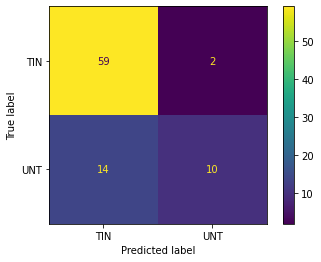

In [492]:
cm = confusion_matrix(y_test_mapped, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(y_test))
disp.plot()
plt.show()

<b>ROC and precision-recall curves</b>

In [493]:
y_test_array = pd.get_dummies(y_test_mapped, drop_first=False).values
classes = y_train.unique()

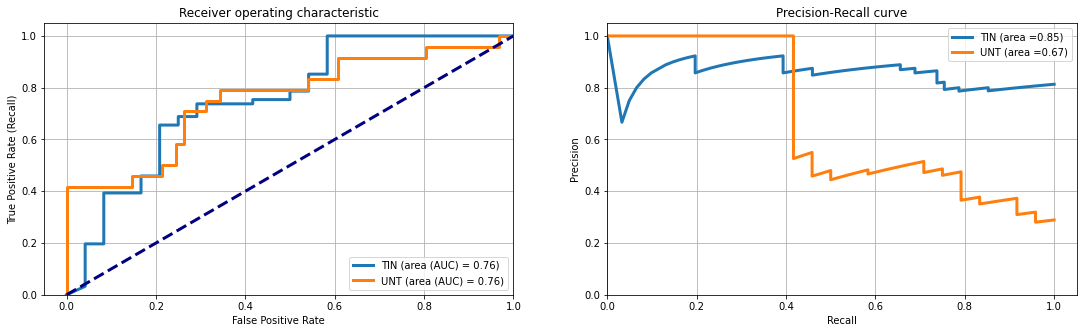

In [494]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18.5, 5)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i], predicted[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area (AUC) = {1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area ={1:0.2f})'.format(classes[i], metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()